### AttentionWithSeq2Seq vs Seq2seq 

In [1]:
import sys
sys.path.append('C:/Users/KimDongyoung/Desktop/Github/my_git/mygit/DEEPLEARNING/밑바닥부터시작하는딥러닝2')
import numpy as np
import matplotlib.pyplot as plt
import sequence as sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq
from common.base_model import BaseModel

In [2]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

In [3]:
x_train.shape

(45000, 29)

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

class Embedding:
    def __init__(self, W):
        self.params = [W] # 가중치 W를 인스턴스 변수 params에 리스트로 저장
        self.grads = [np.zeros_like(W)] # W와 형상이 같은 행렬을 하나 준비, 0으로 초기화
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx] # W의 idx번째 행을 추출
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout) # dW의 self.idx번째 행에 dout을 더함
        return None
    
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

In [ ]:
# Time Embedding
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape # N은 미니배치 크기, T는 시계열 데이터의 길이, 하나의 데이터 당 T개의 단어가 들어있음
        V, D = self.W.shape # V는 어휘 수, D는 단어 벡터의 차원 수 

        out = np.empty((N, T, D), dtype='f') # 출력 데이터 저장용 배열
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

# RNN
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

# LSTM
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


# Time RNN
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

# Tiem Affine
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

# Time Softmax with Loss
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx
    
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

In [ ]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)#.repeat(T, axis=1)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da


class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh


class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec


In [ ]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # embed_W: 입력 데이터의 단어 ID를 단어의 분산 표현으로 변환하는 가중치
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled

In [ ]:
class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)

        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 // 2

        dc, ddec_hs0 = dout[:,:,:H], dout[:,:,H:]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)

        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array([sample_id]).reshape((1, 1))

            out = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c = self.attention.forward(enc_hs, dec_hs)
            out = np.concatenate((c, dec_hs), axis=2)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(sample_id)

        return sampled


class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [ ]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params # 인코더와 디코더의 params를 다 합침
        self.grads = self.encoder.grads + self.decoder.grads    # 인코더와 디코더의 grads를 다 합침

    def forward(self, xs, ts): # xs: 입력 데이터, ts: 정답 레이블
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:] # 정답 레이블에서 첫 번째 문자를 제외한 것이 디코더의 입력, 정답 레이블에서 마지막 문자를 제외한 것이 디코더의 정답 레이블

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h) # 인코더의 은닉 상태 h와 디코더의 입력 데이터를 사용해 점수를 출력
        loss = self.softmax.forward(score, decoder_ts) # 점수와 디코더의 정답 레이블을 사용해 손실을 계산
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [10]:
# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

Training AttentionSeq2seq...
| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 8[s] | 손실 3.10
| 에폭 1 |  반복 41 / 351 | 시간 16[s] | 손실 1.88
| 에폭 1 |  반복 61 / 351 | 시간 25[s] | 손실 1.66
| 에폭 1 |  반복 81 / 351 | 시간 33[s] | 손실 1.33
| 에폭 1 |  반복 101 / 351 | 시간 43[s] | 손실 1.17
| 에폭 1 |  반복 121 / 351 | 시간 50[s] | 손실 1.13
| 에폭 1 |  반복 141 / 351 | 시간 58[s] | 손실 1.08
| 에폭 1 |  반복 161 / 351 | 시간 66[s] | 손실 1.05
| 에폭 1 |  반복 181 / 351 | 시간 74[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 82[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 90[s] | 손실 1.03
| 에폭 1 |  반복 241 / 351 | 시간 99[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 107[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 117[s] | 손실 1.01
| 에폭 1 |  반복 301 / 351 | 시간 128[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 136[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 146[s] | 손실 0.99
Q 10/15/94                     
T 1994-10-15
X 1988-08-21
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1981-08-21
---
Q Mar 25, 2003                 
T 2003-03-25
X 1988-08-21


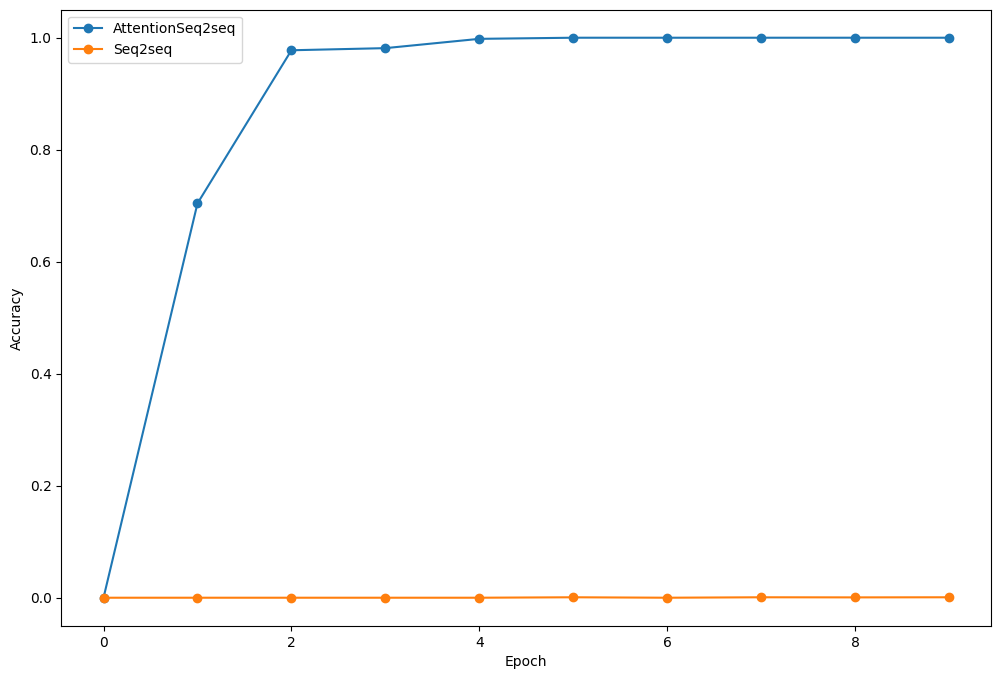

In [11]:
# 모델 리스트
models = {
    "AttentionSeq2seq": AttentionSeq2seq(vocab_size, wordvec_size, hidden_size),
    "Seq2seq": Seq2seq(vocab_size, wordvec_size, hidden_size),
}

results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    optimizer = Adam()
    trainer = Trainer(model, optimizer)

    acc_list = []
    for epoch in range(max_epoch):
        trainer.fit(x_train, t_train, max_epoch=1,
                    batch_size=batch_size, max_grad=max_grad)

        correct_num = 0
        for i in range(len(x_test)):
            question, correct = x_test[[i]], t_test[[i]]
            verbose = i < 10
            correct_num += eval_seq2seq(model, question, correct,
                                        id_to_char, verbose, is_reverse=True)

        acc = float(correct_num) / len(x_test)
        acc_list.append(acc)
        print(f'{model_name} Accuracy %.3f%%' % (acc * 100))

    results[model_name] = acc_list
    model.save_params()

# 그래프 그리기
plt.figure(figsize=(12, 8))
for model_name, acc_list in results.items():
    x = np.arange(len(acc_list))
    plt.plot(x, acc_list, marker='o', label=model_name)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()